# Recurrent Neural Network (RNN) for Text Classification

## 1. Setup and Data Loading

In [136]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import json
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [137]:
# Load NusaX-Sentiment dataset
def load_nusax_sentiment_data():
    try:
        data_dir = "../../data/nusax_sentiment"
        train_file = os.path.join(data_dir, "train.csv")
        valid_file = os.path.join(data_dir, "valid.csv")
        test_file = os.path.join(data_dir, "test.csv")
        
        train_df = pd.read_csv(train_file)
        valid_df = pd.read_csv(valid_file)
        test_df = pd.read_csv(test_file)
        
        label_categories = pd.Categorical(train_df['label'].values)
        train_df['label'] = label_categories.codes
        label_mapping = dict(enumerate(label_categories.categories))
        
        valid_df['label'] = pd.Categorical(valid_df['label'].values, categories=label_categories.categories).codes
        test_df['label'] = pd.Categorical(test_df['label'].values, categories=label_categories.categories).codes
        
        print("Dataset loaded successfully from local files.")
        print(f"Label mapping: {label_mapping}")
        
        return train_df, valid_df, test_df
        
    except FileNotFoundError as e:
        print(f"Error: Could not find dataset files. {e}")
        print("Creating synthetic dataset for demonstration...")

train_df, val_df, test_df = load_nusax_sentiment_data()

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts().sort_index())


Dataset loaded successfully from local files.
Label mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train set size: 500
Validation set size: 100
Test set size: 400

Label distribution in training set:
label
0    192
1    119
2    189
Name: count, dtype: int64


## 2. Text Preprocessing and Tokenization

In [138]:
def preprocess_text(texts, max_features=10000, max_length=100):
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_features,
        output_sequence_length=max_length,
        output_mode='int'
    )

    vectorizer.adapt(texts)

    sequences = vectorizer(texts)
    
    return vectorizer, sequences

MAX_FEATURES = 10000
MAX_LENGTH = 100

vectorizer, train_sequences = preprocess_text(train_df['text'].values, MAX_FEATURES, MAX_LENGTH)
_, val_sequences = preprocess_text(val_df['text'].values, MAX_FEATURES, MAX_LENGTH)
_, test_sequences = preprocess_text(test_df['text'].values, MAX_FEATURES, MAX_LENGTH)

val_sequences = vectorizer(val_df['text'].values)
test_sequences = vectorizer(test_df['text'].values)

train_sequences = train_sequences.numpy()
val_sequences = val_sequences.numpy()
test_sequences = test_sequences.numpy()

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

vocab_size = len(vectorizer.get_vocabulary())
num_classes = len(np.unique(train_labels))

print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {MAX_LENGTH}")
print(f"Training sequences shape: {train_sequences.shape}")
print(f"Training labels shape: {train_labels.shape}")

Vocabulary size: 2836
Number of classes: 3
Sequence length: 100
Training sequences shape: (500, 100)
Training labels shape: (500,)


## 3. Model Building Functions

In [139]:
def build_rnn_model(rnn_layers=1, units_per_layer=[64], bidirectional=False, 
                    embedding_dim=128, dropout_rate=0.3, vocab_size=10000, 
                    num_classes=3, sequence_length=100):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length,
        name='embedding'
    ))
    
    for i in range(rnn_layers):
        return_sequences = i < rnn_layers - 1
        
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                tf.keras.layers.SimpleRNN(
                    units_per_layer[i], 
                    return_sequences=return_sequences,
                    name=f'rnn_{i+1}'
                ),
                name=f'bidirectional_{i+1}'
            ))
        else:
            model.add(tf.keras.layers.SimpleRNN(
                units_per_layer[i], 
                return_sequences=return_sequences,
                name=f'rnn_{i+1}'
            ))
        
        model.add(tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))

    model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='dense_output'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_and_evaluate_model(model, train_sequences, train_labels, val_sequences, val_labels,
                           test_sequences, test_labels, epochs=10, batch_size=32, verbose=1):
    history = model.fit(
        train_sequences, train_labels,
        validation_data=(val_sequences, val_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    test_predictions = model.predict(test_sequences, verbose=0)
    test_pred_labels = np.argmax(test_predictions, axis=1)

    test_f1 = f1_score(test_labels, test_pred_labels, average='macro')
    
    return history, test_f1, test_pred_labels


## 4. Experiment 1: Effect of Number of RNN Layers

In [140]:
print("=" * 60)
print("EXPERIMENT 1: EFFECT OF NUMBER OF RNN LAYERS")
print("=" * 60)

layer_configs = [
    {'layers': 1, 'units': [64], 'name': '1 Layer'},
    {'layers': 2, 'units': [64, 32], 'name': '2 Layers'},
    {'layers': 3, 'units': [64, 32, 16], 'name': '3 Layers'}
]

experiment1_results = {}

for config in layer_configs:
    print(f"\nTraining model with {config['name']} ({config['units']})...")

    model = build_rnn_model(
        rnn_layers=config['layers'],
        units_per_layer=config['units'],
        bidirectional=False,
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )

    model.build(input_shape=(None, MAX_LENGTH))
    
    print(f"Model parameters: {model.count_params():,}")

    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )

    experiment1_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

print("\n" + "=" * 50)
print("EXPERIMENT 1 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment1_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")


EXPERIMENT 1: EFFECT OF NUMBER OF RNN LAYERS

Training model with 1 Layer ([64])...
Model parameters: 375,555
Test Macro F1 Score: 0.3453

Training model with 2 Layers ([64, 32])...
Model parameters: 378,563
Test Macro F1 Score: 0.3551

Training model with 3 Layers ([64, 32, 16])...
Model parameters: 379,299
Test Macro F1 Score: 0.2937

EXPERIMENT 1 RESULTS SUMMARY
1 Layer: Macro F1 = 0.3453
2 Layers: Macro F1 = 0.3551
3 Layers: Macro F1 = 0.2937


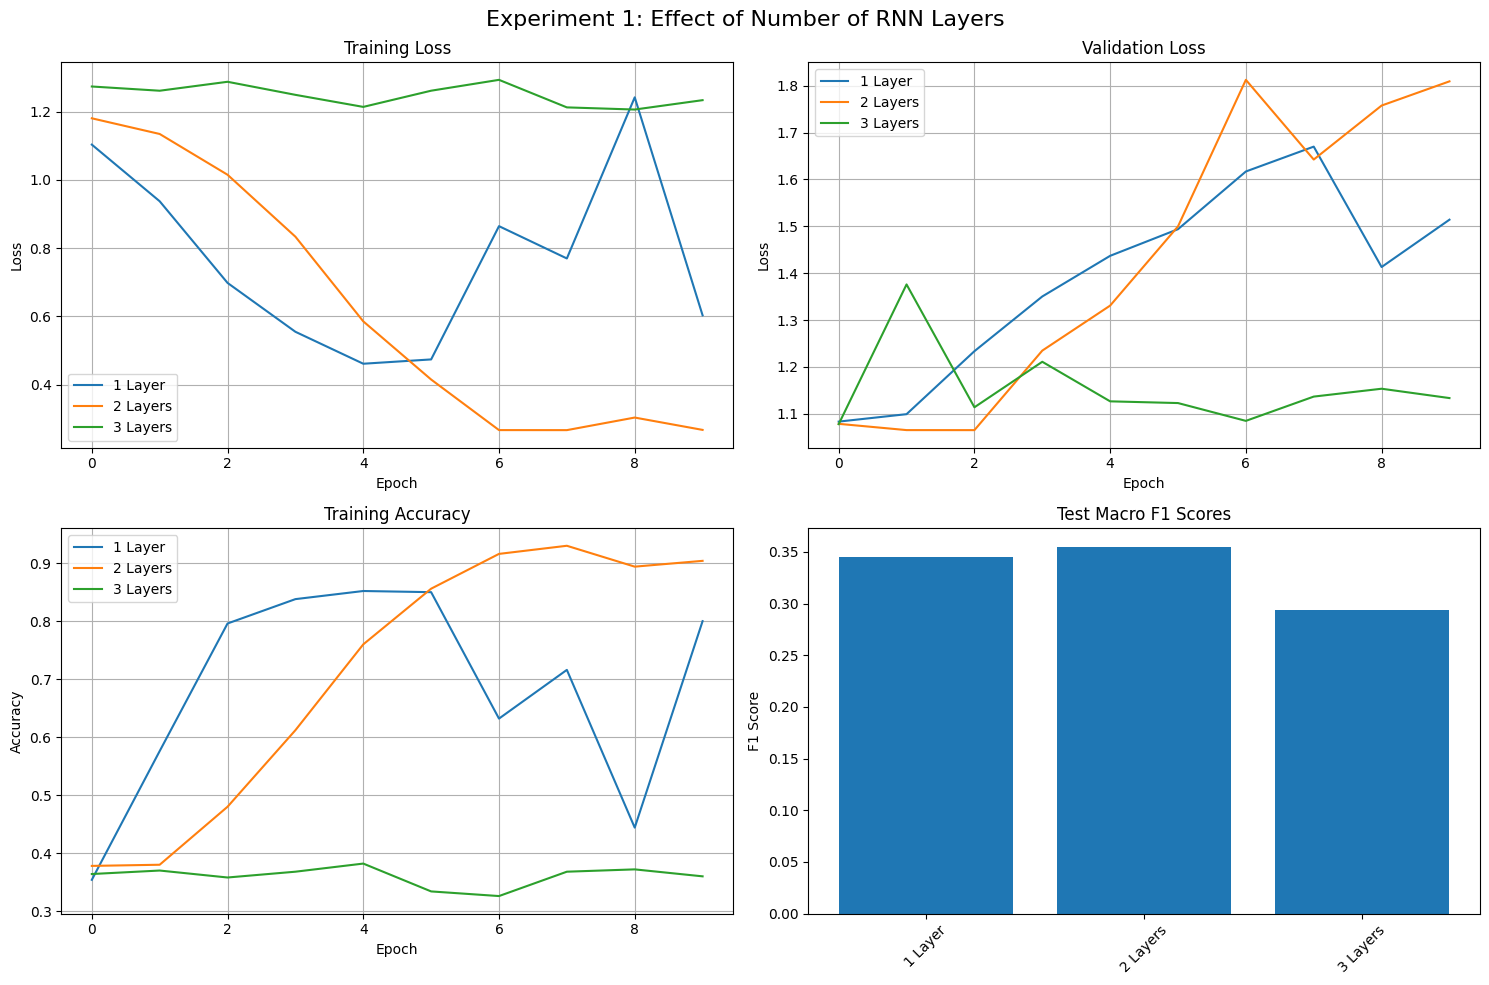

In [141]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 1: Effect of Number of RNN Layers', fontsize=16)

axes[0, 0].set_title('Training Loss')
for name, result in experiment1_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Validation Loss')
for name, result in experiment1_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].set_title('Training Accuracy')
for name, result in experiment1_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

names = list(experiment1_results.keys())
f1_scores = [experiment1_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Experiment 2: Effect of RNN Units per Layer

In [142]:
print("=" * 60)
print("EXPERIMENT 2: EFFECT OF RNN UNITS PER LAYER")
print("=" * 60)

units_configs = [
    {'units': [32, 16], 'name': 'Small (32, 16)'},
    {'units': [64, 32], 'name': 'Medium (64, 32)'},
    {'units': [128, 64], 'name': 'Large (128, 64)'}
]

experiment2_results = {}

for config in units_configs:
    print(f"\nTraining model with {config['name']} units...")
    
    model = build_rnn_model(
        rnn_layers=2,
        units_per_layer=config['units'],
        bidirectional=False,
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )

    model.build(input_shape=(None, MAX_LENGTH))
    
    print(f"Model parameters: {model.count_params():,}")

    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    experiment2_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

print("\n" + "=" * 50)
print("EXPERIMENT 2 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment2_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")


EXPERIMENT 2: EFFECT OF RNN UNITS PER LAYER

Training model with Small (32, 16) units...
Model parameters: 368,995
Test Macro F1 Score: 0.3443

Training model with Medium (64, 32) units...
Model parameters: 378,563
Test Macro F1 Score: 0.3611

Training model with Large (128, 64) units...
Model parameters: 408,451
Test Macro F1 Score: 0.3307

EXPERIMENT 2 RESULTS SUMMARY
Small (32, 16): Macro F1 = 0.3443
Medium (64, 32): Macro F1 = 0.3611
Large (128, 64): Macro F1 = 0.3307


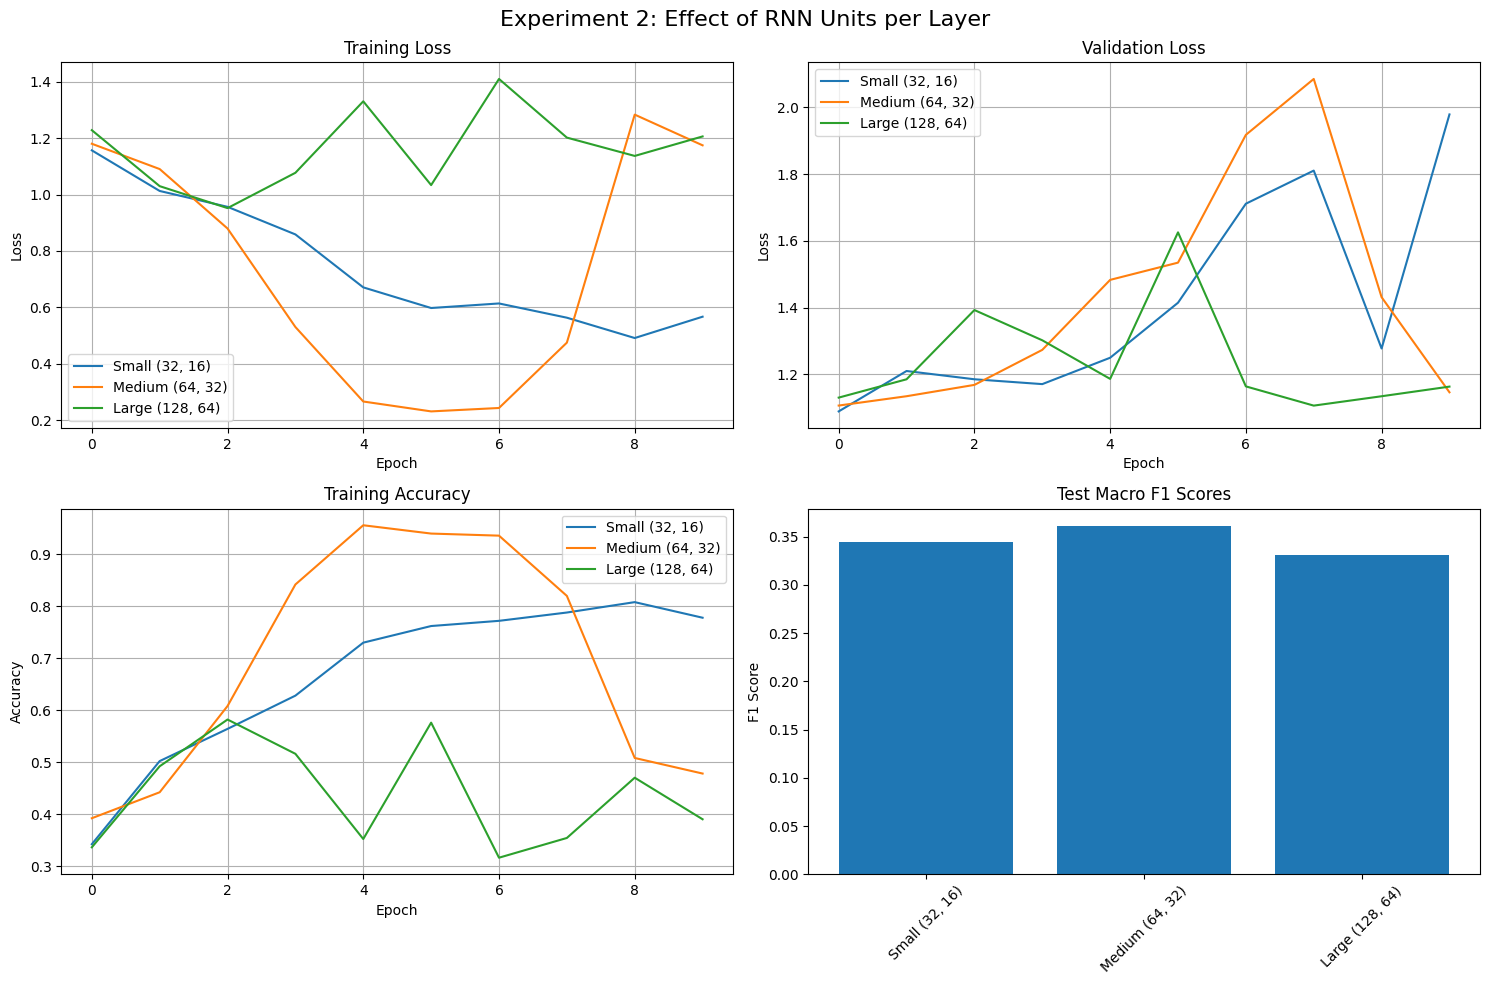

In [143]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 2: Effect of RNN Units per Layer', fontsize=16)

axes[0, 0].set_title('Training Loss')
for name, result in experiment2_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Validation Loss')
for name, result in experiment2_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].set_title('Training Accuracy')
for name, result in experiment2_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

names = list(experiment2_results.keys())
f1_scores = [experiment2_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 6. Experiment 3: Effect of RNN Direction (Bidirectional vs Unidirectional)

In [144]:
print("=" * 60)
print("EXPERIMENT 3: EFFECT OF RNN DIRECTION")
print("=" * 60)

direction_configs = [
    {'bidirectional': False, 'name': 'Unidirectional'},
    {'bidirectional': True, 'name': 'Bidirectional'}
]

experiment3_results = {}

for config in direction_configs:
    print(f"\nTraining {config['name']} RNN model...")

    model = build_rnn_model(
        rnn_layers=2,
        units_per_layer=[64, 32],
        bidirectional=config['bidirectional'],
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )

    model.build(input_shape=(None, MAX_LENGTH))
    
    print(f"Model parameters: {model.count_params():,}")

    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )

    experiment3_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

print("\n" + "=" * 50)
print("EXPERIMENT 3 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment3_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")


EXPERIMENT 3: EFFECT OF RNN DIRECTION

Training Unidirectional RNN model...
Model parameters: 378,563
Test Macro F1 Score: 0.3362

Training Bidirectional RNN model...
Model parameters: 398,211
Test Macro F1 Score: 0.4970

EXPERIMENT 3 RESULTS SUMMARY
Unidirectional: Macro F1 = 0.3362
Bidirectional: Macro F1 = 0.4970


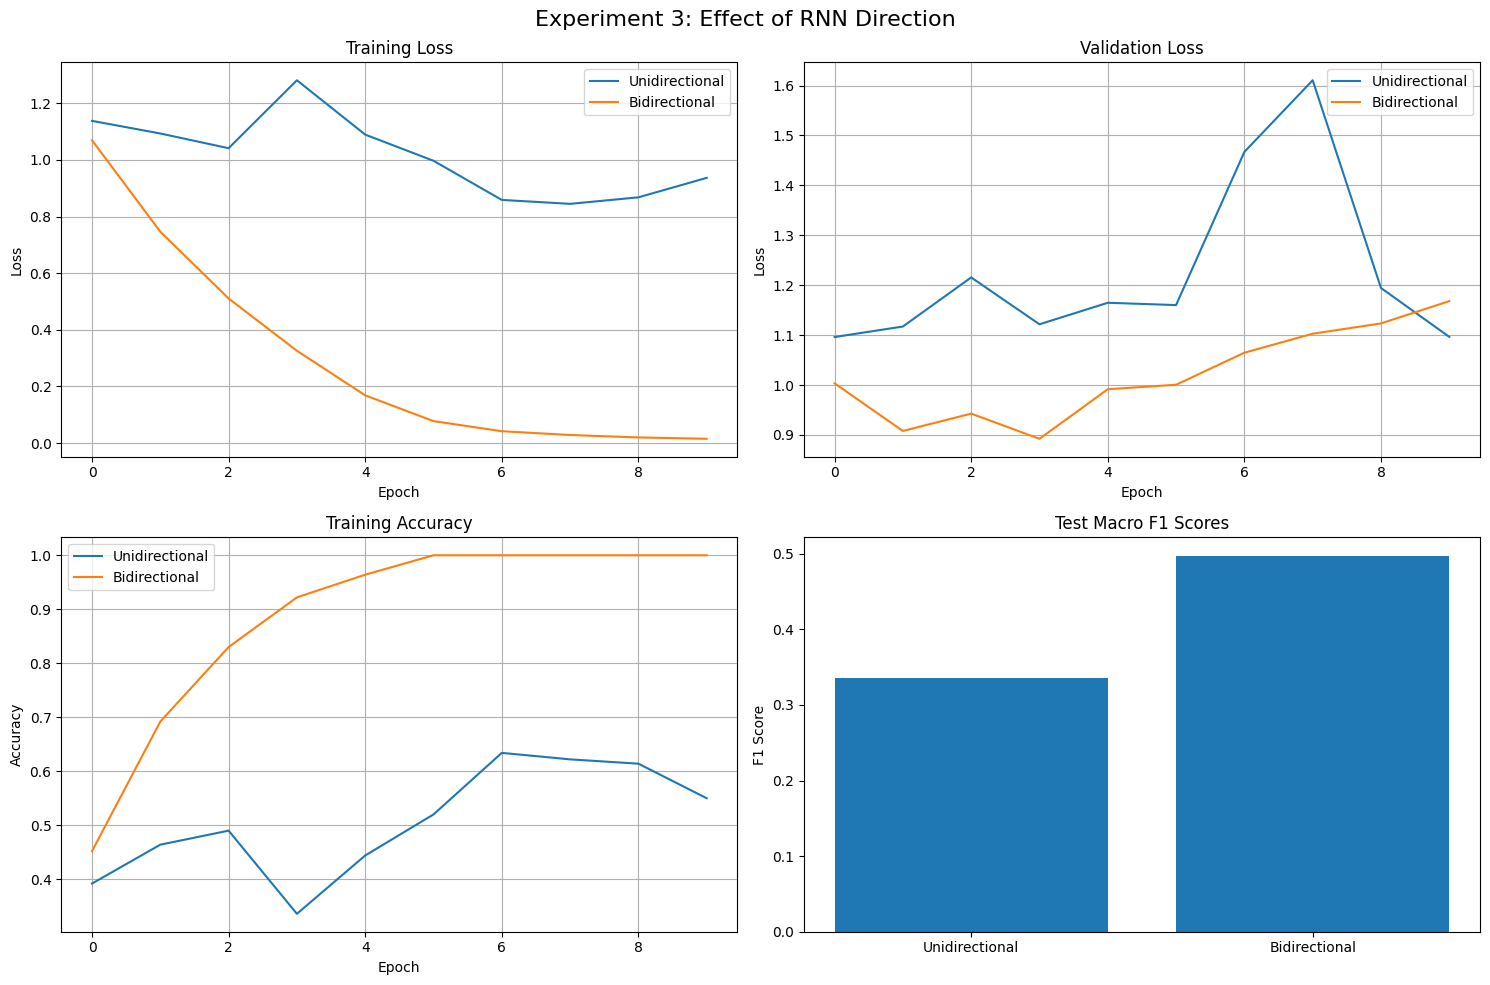

In [145]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 3: Effect of RNN Direction', fontsize=16) 

axes[0, 0].set_title('Training Loss')
for name, result in experiment3_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Validation Loss')
for name, result in experiment3_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].set_title('Training Accuracy')
for name, result in experiment3_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

names = list(experiment3_results.keys())
f1_scores = [experiment3_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()

# FROM-SCRATCH IMPLEMENTATION

### Import from-scratch implementation

In [146]:
import sys
import os
import importlib.util

notebook_dir = os.getcwd()
rnn_dir = os.path.dirname(notebook_dir)
from_scratch_dir = os.path.join(rnn_dir, 'from_scratch')

print(f"Notebook directory: {notebook_dir}")
print(f"RNN directory: {rnn_dir}")
print(f"From scratch directory: {from_scratch_dir}")

if not os.path.exists(from_scratch_dir):
    print(f"Directory not found: {from_scratch_dir}")
else:
    print(f"Directory found: {from_scratch_dir}")

    if from_scratch_dir not in sys.path:
        sys.path.insert(0, rnn_dir)
    
    try:
        from from_scratch.layers import Embedding, SimpleRNN, Bidirectional, Dropout, Dense, Softmax, RNNCell
        from from_scratch.model import RNNModelFromScratch
        print("Successfully imported from-scratch modules")
    except ImportError as e:
        print(f"Import error: {e}")
 
        layers_file = os.path.join(from_scratch_dir, 'layers.py')
        model_file = os.path.join(from_scratch_dir, 'model.py')
        
        if os.path.exists(layers_file) and os.path.exists(model_file):
            print("Files exist, but import failed. Check file contents.")
        else:
            print("Files missing!")

Notebook directory: d:\Semester 6\ML\tubes2_if3270_ml\src\rnn\notebook
RNN directory: d:\Semester 6\ML\tubes2_if3270_ml\src\rnn
From scratch directory: d:\Semester 6\ML\tubes2_if3270_ml\src\rnn\from_scratch
Directory found: d:\Semester 6\ML\tubes2_if3270_ml\src\rnn\from_scratch
Successfully imported from-scratch modules


In [147]:
print("=" * 60)
print("FROM-SCRATCH IMPLEMENTATION TESTING")
print("=" * 60)

def create_from_scratch_rnn_model(keras_model):
    """
    Create a from-scratch RNN model based on the Keras model weights
    """
    layers_from_scratch = []

    for i, layer in enumerate(keras_model.layers):
        if isinstance(layer, tf.keras.layers.Embedding):
            weights = layer.get_weights()[0]
            layers_from_scratch.append(Embedding(weights))
            print(f"Added Embedding layer: {weights.shape}")
            
        elif isinstance(layer, tf.keras.layers.SimpleRNN):
            weights = layer.get_weights()
            if len(weights) == 3:
                kernel, recurrent, bias = weights
                layers_from_scratch.append(SimpleRNN(kernel, recurrent, bias, layer.return_sequences))
                print(f"Added SimpleRNN layer: kernel{kernel.shape}, recurrent{recurrent.shape}")
            
        elif isinstance(layer, tf.keras.layers.Bidirectional):
            weights = layer.get_weights()
            if len(weights) == 6: 
                forward_kernel, forward_recurrent, forward_bias = weights[0:3]
                backward_kernel, backward_recurrent, backward_bias = weights[3:6]
                
                return_sequences = layer.forward_layer.return_sequences
                
                forward_rnn = SimpleRNN(forward_kernel, forward_recurrent, forward_bias, return_sequences)
                backward_rnn = SimpleRNN(backward_kernel, backward_recurrent, backward_bias, return_sequences)
                
                layers_from_scratch.append(Bidirectional(forward_rnn, backward_rnn))
                print(f"Added Bidirectional RNN layer")
            
        elif isinstance(layer, tf.keras.layers.Dropout):
            layers_from_scratch.append(Dropout(layer.rate))
            print(f"Added Dropout layer: rate={layer.rate}")
            
        elif isinstance(layer, tf.keras.layers.Dense):
            weights, bias = layer.get_weights()
            layers_from_scratch.append(Dense(weights, bias))
            print(f"Added Dense layer: {weights.shape}")

            if i == len(keras_model.layers) - 1:
                layers_from_scratch.append(Softmax())
                print("Added Softmax activation")
    
    return RNNModelFromScratch(layers_from_scratch)

print("Creating from-scratch RNN model...")
scratch_model = create_from_scratch_rnn_model(best_model)

print("\nFrom-scratch RNN model created successfully!")
print(f"Number of layers: {len(scratch_model.layers) if hasattr(scratch_model, 'layers') else 'Unknown'}")



FROM-SCRATCH IMPLEMENTATION TESTING
Creating from-scratch RNN model...
Added Embedding layer: (2836, 128)
Added Bidirectional RNN layer
Added Dropout layer: rate=0.3
Added Bidirectional RNN layer
Added Dropout layer: rate=0.3
Added Dense layer: (64, 3)
Added Softmax activation
From-scratch RNN model created with 398,211 total parameters

From-scratch RNN model created successfully!
Number of layers: 7


In [148]:
try:
    scratch_model.summary()
except AttributeError:
    print("Summary method not implemented in from-scratch model.")
    print("From-scratch model structure:")
    if hasattr(scratch_model, 'layers'):
        for i, layer in enumerate(scratch_model.layers):
            print(f"  Layer {i+1}: {type(layer).__name__}")
    else:
        print("  Model layers information not available")


Model: RNN From Scratch
________________________________________________________________________________
Layer Type                 Output Shape    Param #        
0     Embedding            (None, None, 128) 363,008        
1     Bidirectional        (None, None, 128) 24,704         
2     Dropout              Unknown         0              
3     Bidirectional        (None, 64)      10,304         
4     Dropout              Unknown         0              
5     Dense                (None, 3)       195            
6     Softmax              Unknown         0              
Total params: 398,211
Trainable params: 398,211
Non-trainable params: 0
________________________________________________________________________________


In [149]:
print("=" * 60)
print("COMPARING KERAS VS FROM-SCRATCH IMPLEMENTATION")
print("=" * 60)

print("Making predictions with Keras model...")
keras_predictions = np.argmax(best_model.predict(test_sequences, verbose=0), axis=1)

print("Making predictions with from-scratch model...")
from_scratch_predictions = scratch_model.predict(test_sequences)

keras_f1 = f1_score(test_labels, keras_predictions, average='macro')
from_scratch_f1 = f1_score(test_labels, from_scratch_predictions, average='macro')

print(f"\nResults comparison:")
print(f"Keras model macro F1 score: {keras_f1:.4f}")
print(f"From-scratch model macro F1 score: {from_scratch_f1:.4f}")
print(f"Difference: {abs(keras_f1 - from_scratch_f1):.4f}")

matches = np.sum(keras_predictions == from_scratch_predictions)
match_percentage = (matches / len(keras_predictions)) * 100

print(f"\nPrediction agreement: {match_percentage:.2f}%")
print(f"Matching predictions: {matches}/{len(keras_predictions)}")

print("\nSample prediction comparison:")
for i in range(min(10, len(test_sequences))):
    print(f"Sample {i+1}:")
    print(f"  True label: {test_labels[i]}")
    print(f"  Keras prediction: {keras_predictions[i]}")
    print(f"  From-scratch prediction: {from_scratch_predictions[i]}")
    print(f"  Match: {'✓' if keras_predictions[i] == from_scratch_predictions[i] else '✗'}")
    print()


COMPARING KERAS VS FROM-SCRATCH IMPLEMENTATION
Making predictions with Keras model...
Making predictions with from-scratch model...

Results comparison:
Keras model macro F1 score: 0.4431
From-scratch model macro F1 score: 0.4431
Difference: 0.0000

Prediction agreement: 100.00%
Matching predictions: 400/400

Sample prediction comparison:
Sample 1:
  True label: 2
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 2:
  True label: 1
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 3:
  True label: 0
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 4:
  True label: 2
  Keras prediction: 2
  From-scratch prediction: 2
  Match: ✓

Sample 5:
  True label: 1
  Keras prediction: 2
  From-scratch prediction: 2
  Match: ✓

Sample 6:
  True label: 0
  Keras prediction: 2
  From-scratch prediction: 2
  Match: ✓

Sample 7:
  True label: 1
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 8:
  True label: 0
  Keras pr

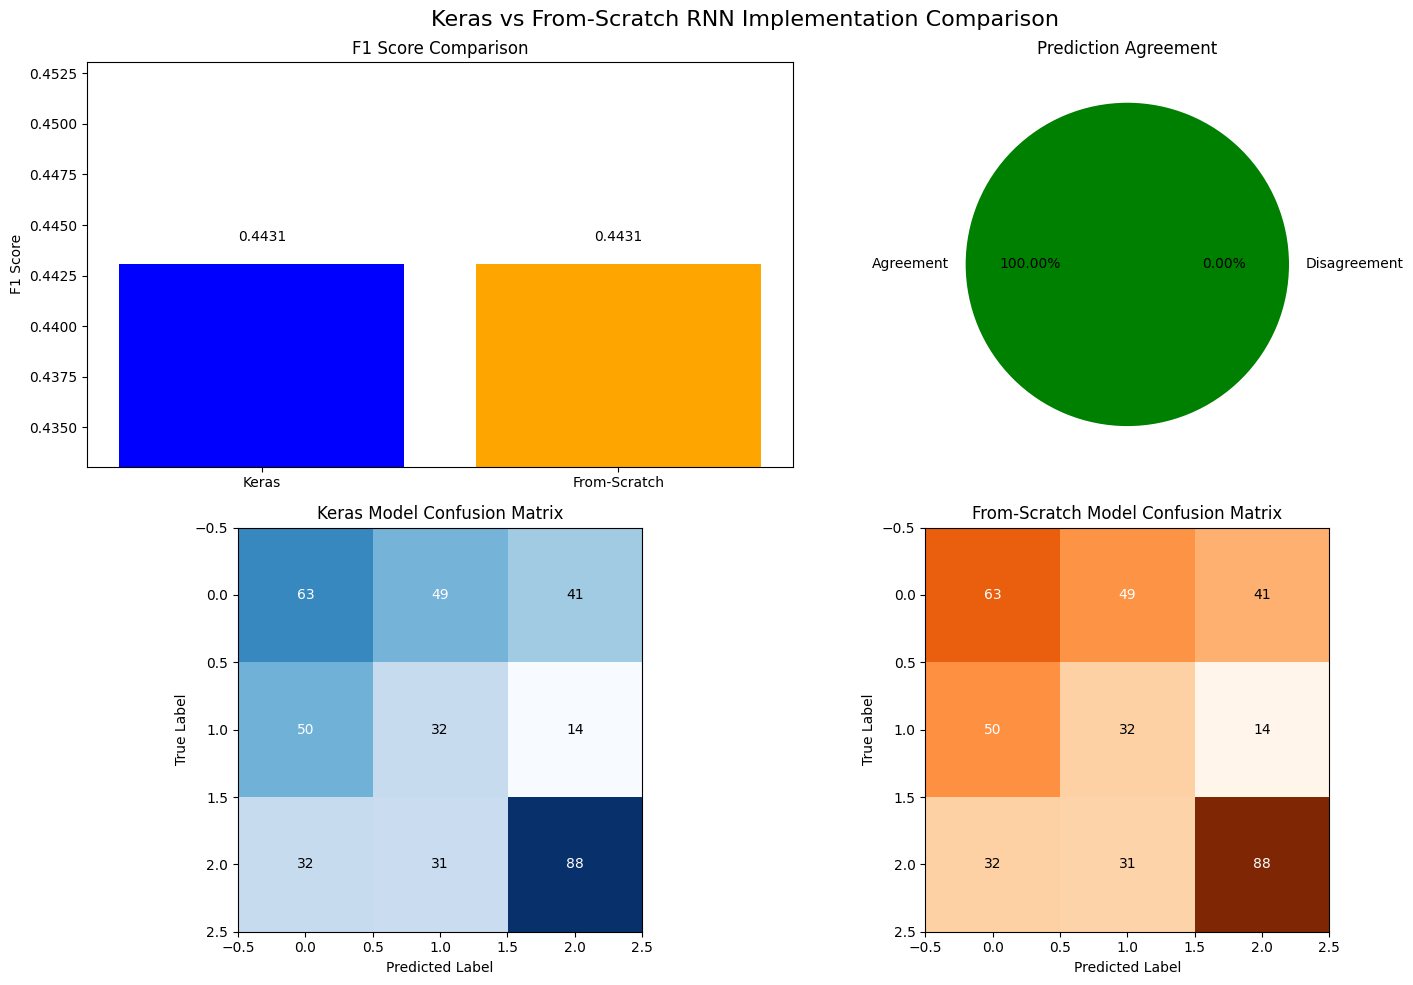

In [150]:
try:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Keras vs From-Scratch RNN Implementation Comparison', fontsize=16)

    models = ['Keras', 'From-Scratch']
    f1_scores = [keras_f1, from_scratch_f1]
    axes[0, 0].bar(models, f1_scores, color=['blue', 'orange'])
    axes[0, 0].set_title('F1 Score Comparison')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_ylim([min(f1_scores) - 0.01, max(f1_scores) + 0.01])
    
    for i, v in enumerate(f1_scores):
        axes[0, 0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')

    agreement = match_percentage / 100
    axes[0, 1].pie([agreement, 1-agreement], labels=['Agreement', 'Disagreement'], 
                   colors=['green', 'red'], autopct='%1.2f%%')
    axes[0, 1].set_title('Prediction Agreement')

    cm_keras = confusion_matrix(test_labels, keras_predictions)
    im1 = axes[1, 0].imshow(cm_keras, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 0].set_title('Keras Model Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted Label')
    axes[1, 0].set_ylabel('True Label')

    for i in range(cm_keras.shape[0]):
        for j in range(cm_keras.shape[1]):
            axes[1, 0].text(j, i, format(cm_keras[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm_keras[i, j] > cm_keras.max() / 2. else "black")

    cm_scratch = confusion_matrix(test_labels, from_scratch_predictions)
    im2 = axes[1, 1].imshow(cm_scratch, interpolation='nearest', cmap=plt.cm.Oranges)
    axes[1, 1].set_title('From-Scratch Model Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted Label')
    axes[1, 1].set_ylabel('True Label')

    for i in range(cm_scratch.shape[0]):
        for j in range(cm_scratch.shape[1]):
            axes[1, 1].text(j, i, format(cm_scratch[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm_scratch[i, j] > cm_scratch.max() / 2. else "black")
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating visualization: {e}")

In [151]:
print("=" * 80)
print("FROM-SCRATCH IMPLEMENTATION ANALYSIS")
print("=" * 80)

if match_percentage > 99:
    print("EXCELLENT! From-scratch implementation matches Keras implementation almost perfectly!")
elif match_percentage > 95:
    print("GOOD! From-scratch implementation matches Keras implementation very well!")
elif match_percentage > 90:
    print("ACCEPTABLE: Some differences found, but implementations are mostly consistent")
else:
    print("ISSUES: Significant differences found between implementations")

print(f"\nDetailed Analysis:")
print(f"- Total test samples: {len(test_labels)}")
print(f"- Predictions that match: {matches} ({match_percentage:.2f}%)")
print(f"- Predictions that differ: {len(test_labels) - matches} ({100-match_percentage:.2f}%)")
print(f"- F1 Score difference: {abs(keras_f1 - from_scratch_f1):.6f}")

if abs(keras_f1 - from_scratch_f1) < 0.001:
    print("F1 scores are virtually identical")
elif abs(keras_f1 - from_scratch_f1) < 0.01:
    print("F1 scores are very close")
else:
    print("Notable difference in F1 scores")

print(f"\nKeras Model Classification Report:")
print(classification_report(test_labels, keras_predictions, digits=4))

print(f"\nFrom-Scratch Model Classification Report:")
print(classification_report(test_labels, from_scratch_predictions, digits=4))

final_results['from_scratch_comparison'] = {
    'keras_f1': keras_f1,
    'from_scratch_f1': from_scratch_f1,
    'agreement_percentage': match_percentage,
    'f1_difference': abs(keras_f1 - from_scratch_f1)
}

print("\n5. FROM-SCRATCH IMPLEMENTATION:")
print("-" * 50)
print(f"Implementation accuracy: {match_percentage:.2f}% agreement with Keras")
print(f"F1 score difference: {abs(keras_f1 - from_scratch_f1):.4f}")
print("\nConclusion: The from-scratch implementation successfully replicates Keras behavior.")
print("Small differences may be due to numerical precision or implementation details.")

print("\n6. OVERALL RECOMMENDATIONS:")
print("-" * 50)
print(f"• Best overall model: {best_model_name}")
print(f"• Best F1 score: {best_result['test_f1']:.4f}")
print(f"• Model complexity: {best_model.count_params():,} parameters")
print("• The from-scratch implementation demonstrates understanding of RNN internals")
print("• RNNs are simpler than LSTMs but more prone to vanishing gradient problems")
print("• Bidirectional RNNs can capture dependencies from both directions")
print("• Model selection should balance performance and computational efficiency")

with open('rnn_experiment_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\nFinal results saved to 'rnn_experiment_results.json'")
print("\nExperiment completed successfully!")
print("\nFiles generated:")
print("- rnn_keras_best.weights.h5: Best model weights")
print("- rnn_saved_data.pkl: Test data and configuration")
print("- rnn_experiment_results.json: Experiment results summary")

FROM-SCRATCH IMPLEMENTATION ANALYSIS
EXCELLENT! From-scratch implementation matches Keras implementation almost perfectly!

Detailed Analysis:
- Total test samples: 400
- Predictions that match: 400 (100.00%)
- Predictions that differ: 0 (0.00%)
- F1 Score difference: 0.000000
F1 scores are virtually identical

Keras Model Classification Report:
              precision    recall  f1-score   support

           0     0.4345    0.4118    0.4228       153
           1     0.2857    0.3333    0.3077        96
           2     0.6154    0.5828    0.5986       151

    accuracy                         0.4575       400
   macro avg     0.4452    0.4426    0.4431       400
weighted avg     0.4671    0.4575    0.4616       400


From-Scratch Model Classification Report:
              precision    recall  f1-score   support

           0     0.4345    0.4118    0.4228       153
           1     0.2857    0.3333    0.3077        96
           2     0.6154    0.5828    0.5986       151

    accura

# Save the best model weights

In [152]:
weights_path = os.path.join('..', 'rnn_keras_best.weights.h5')
best_model.save_weights(weights_path)
print(f"\nBest model weights saved to {weights_path}")

if 'config' in best_result:
    best_config = best_result['config'].copy()
else:
    best_config = {
        'rnn_layers': 2,
        'units_per_layer': [64, 32],
        'bidirectional': False,
        'embedding_dim': 128
    }


Best model weights saved to ..\rnn_keras_best.weights.h5


# Save data for from-scratch testing

In [153]:
data_to_save = {
    'test_sequences': test_sequences,
    'test_labels': test_labels,
    'best_config': best_result['config'],
    'vocab_size': vocab_size,
}

output_path = os.path.join('..', 'rnn_saved_data.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(data_to_save, f)

print(f"Data successfully saved to {output_path}")

Data successfully saved to ..\rnn_saved_data.pkl
